In [1]:
%reload_ext autoreload
%autoreload 1
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from IPython import display
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_accepted=pl.read_csv('data/accepted_2007_to_2018Q4.csv',dtypes={'id':str})

In [4]:
data_accepted['id'].is_duplicated().any()

False

In [5]:
data_rejected=pl.read_csv('data/rejected_2007_to_2018Q4.csv')

In [6]:
data_rejected.shape

(27648741, 9)

In [7]:
data_accepted.shape

(2260701, 151)

In [8]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,str,f64,str,str,str,str,f64
1000.0,"""2007-05-26""","""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,"""2007-05-26""","""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,"""2007-05-27""","""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,"""2007-05-27""","""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,"""2007-05-27""","""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


In [9]:
data_accepted.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
"""68407277""",null,3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,…,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68355089""",null,24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""small_business…","""Business""","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,…,24667.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68341763""",null,20000.0,20000.0,20000.0,""" 60 months""",10.78,432.66,"""B""","""B4""","""truck driver""","""10+ years""","""MORTGAGE""",63000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""home_improveme…",null,"""605xx""","""IL""",10.78,0.0,"""Aug-2000""",695.0,699.0,0.0,null,null,6.0,0.0,7869.0,56.2,18.0,…,14877.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""66310712""",null,35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…","""Dec-2015""","""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,…,18000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68476807""",null,10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""m

In [10]:
data_accepted=data_accepted.with_columns(pl.col('issue_d').str.to_date("%b-%Y").alias('issue_d'))
data_rejected=data_rejected.with_columns(pl.col('Application Date').str.to_date("%Y-%m-%d").alias('Application Date'))

In [11]:
data_accepted.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,date,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
"""68407277""",null,3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,…,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68355089""",null,24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""small_business…","""Business""","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,…,24667.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68341763""",null,20000.0,20000.0,20000.0,""" 60 months""",10.78,432.66,"""B""","""B4""","""truck driver""","""10+ years""","""MORTGAGE""",63000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""home_improveme…",null,"""605xx""","""IL""",10.78,0.0,"""Aug-2000""",695.0,699.0,0.0,null,null,6.0,0.0,7869.0,56.2,18.0,…,14877.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""66310712""",null,35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…",2015-12-01,"""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,…,18000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68476807""",null,10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""major_purchase…","""

In [15]:
data_accepted.null_count()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,2260668,0,0,0,0,0,0,0,0,166969,146907,0,4,0,0,0,0,0,2134601,0,23325,1,0,1711,29,29,0,0,30,1158502,1901512,29,29,0,1802,29,…,70276,2152648,2152647,2152647,2152647,2152647,2152647,2152647,2154484,2152647,2152647,2152647,2152647,2224726,0,2249751,2249751,2249751,2249751,2249751,2249751,2249751,2249751,2249751,2249751,2249751,2252017,2249751,2249751,0,0,2226422,2226422,2226422,2226422,2226422,2226422


In [13]:
data_accepted=data_accepted.filter(data_accepted['loan_amnt'].is_not_null())

In [12]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,date,str,f64,str,str,str,str,f64
1000.0,2007-05-26,"""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,2007-05-26,"""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,2007-05-27,"""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,2007-05-27,"""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,2007-05-27,"""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


In [13]:
data_accepted['dti'].max()

999.0

In [14]:
data_accepted.filter(data_accepted['dti']==999)['dti_joint'].is_null().any()

False

In [15]:
data_accepted.find_idx_by_name('dti')

24

In [16]:
data_accepted.filter(data_accepted['dti']>900)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,date,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
"""67405134""",null,6550.0,6550.0,6550.0,""" 36 months""",17.86,236.34,"""D""","""D5""",null,null,"""MORTGAGE""",1770.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""credit_card""","""Credit card re…","""773xx""","""TX""",999.0,2.0,"""Jul-1991""",670.0,674.0,0.0,9.0,null,10.0,0.0,29029.0,84.4,25.0,…,21909.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""130431143""",null,10000.0,10000.0,10000.0,""" 36 months""",6.07,304.54,"""A""","""A2""",null,null,"""OWN""",40.0,"""Verified""",2018-03-01,"""Current""","""n""","""https://lendin…",null,"""credit_card""","""Credit card re…","""302xx""","""GA""",999.0,0.0,"""May-1974""",835.0,839.0,0.0,null,null,4.0,0.0,1175.0,6.4,9.0,…,25034.0,"""3763.0""","""570.0""","""574.0""","""Oct-2007""","""2.0""","""0.0""","""1.0""",null,"""1.0""","""3.0""","""0.0""","""2.0""","""17.0""","""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""130393601""",null,25000.0,25000.0,25000.0,""" 36 months""",21.85,952.83,"""D""","""D5""",null,null,"""RENT""",850.0,"""Verified""",2018-03-01,"""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""385xx""","""TN""",999.0,0.0,"""Oct-1999""",685.0,689.0,0.0,28.0,null,12.0,0.0,29543.0,86.6,24.0,…,30906.0,"""43075.0""","""620.0""","""624.0""","""Jul-2000""","""0.0""","""2.0""","""3.0""","""60.9""","""1.0""","""9.0""","""0.0""","""0.0""","""19.0""","""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""129833352""",null,24000.0,24000.0,24000.0,""" 36 months""",9.92,773.52,"""B""","""B2""","""Teacher""","""10+ years""","""MORTGAGE""",60.0,"""Not Verified""",2018-03-01,"""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""440xx""","""OH""",999.0,0.0,"""Aug-2000""",670.0,674.0,0.0,25.0,null,8.0,0.0,0.0,null,41.0,…,61716.0,"""34888.0""","""630.0""","""634.0""","""Dec-2000""","""3.0""","""4.0""","""24.0""","""46.9""","""10.0""","""21.0""","""0.0""","""0.0""","""25.0""","""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""129679050""",null,8000.0,8000.0,8000.0,""" 36 months""",7.96,250.55,"""A""","""A5""","""Driver""","""1 ye

In [17]:
data_accepted_merged_dti=data_accepted.with_columns(
    pl.when(pl.col("dti") == 999)
    .then(pl.col("dti_joint"))
    .otherwise(pl.col("dti"))
    .alias("dti")
)

### Join procedure

In [18]:
data_accepted_merged_dti = data_accepted_merged_dti.with_columns(pl.lit(np.int8(1)).alias('policy_code'))

In [19]:
data_rejected = data_rejected.with_columns(pl.lit(np.int8(0)).alias('Policy Code'))

In [20]:
data_rejected = data_rejected.with_columns(
    data_rejected["Debt-To-Income Ratio"]
    .map_elements(lambda x: np.float32(x.rstrip("%")))
    .alias("Debt-To-Income Ratio")
)

In [21]:
data_full = pl.concat(
    [
        data_rejected.select(
            pl.col("Application Date"),
            pl.col("Amount Requested"),
            pl.col("Loan Title"),
            pl.col("Debt-To-Income Ratio"),
            pl.col("Zip Code"),
            pl.col("State"),
            pl.col("Employment Length"),
            pl.col("Policy Code"),
        ),
        data_accepted_merged_dti.select(
            pl.col("issue_d").alias("Application Date"),
            pl.col('loan_amnt').alias("Amount Requested"),
            pl.col('title').alias("Loan Title"),
            pl.col('dti').alias("Debt-To-Income Ratio"),
            pl.col('zip_code').alias("Zip Code"),
            pl.col('addr_state').alias("State"),
            pl.col('emp_length').alias("Employment Length"),
            pl.col('policy_code').alias("Policy Code"),
        ),
    ]
)

#### by year

#### Splits

# stop here

In [54]:
null_counts = data_full.null_count() / len(data_full)*100
for col in null_counts.columns:
    null_counts = null_counts.with_columns(
        pl.col(col).map_elements(lambda x: f"{x:.2f}%").alias(col)
    )
null_counts

Application Date,Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,title,month,month_sin,month_cos
str,str,str,str,str,str,str,str,str,str,str,str
"""0.00%""","""0.00%""","""0.08%""","""4.03%""","""0.00%""","""0.00%""","""3.67%""","""0.00%""","""16.75%""","""0.00%""","""0.00%""","""0.00%"""


In [24]:
data_full.select(pl.selectors.by_dtype(pl.NUMERIC_DTYPES)).describe()

describe,Amount Requested,Debt-To-Income Ratio,Policy Code
str,f64,f64,f64
"""count""",2.9909442e7,2.9909442e7,2.9909442e7
"""null_count""",33.0,1744.0,0.0
"""mean""",13277.884418,133.93084,0.075585
"""std""",14659.491717,10133.387089,0.264333
"""min""",0.0,-1.0,0.0
"""25%""",5000.0,8.55,0.0
"""50%""",10000.0,19.68,0.0
"""75%""",20000.0,35.099998,0.0
"""max""",1.4e6,5.0000032e7,1.0


In [25]:
data_full = dmf.text_preprocessing_wo_training(data_full)

title_imputer = tr.NotInImputerPolars(fill_value=None, cat_no=12)
data_full = data_full.with_columns(
    title_imputer.fit_transform(data_full["title"].alias("title"))
)

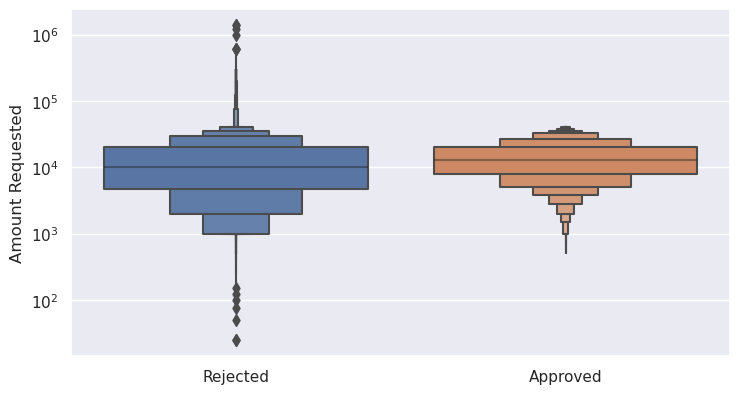

In [26]:
fig_requested_box, ax_requested_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=data_full.select(["Amount Requested", "Policy Code"]).drop_nulls()['Policy Code'].to_numpy(),
    y=data_full.select(["Amount Requested", "Policy Code"]).drop_nulls()["Amount Requested"].to_numpy(),
    ax=ax_requested_box
)
ax_requested_box.set_yscale("log")
ax_requested_box.set_ylabel("Amount Requested")
ax_requested_box.set_xticklabels(('Rejected','Approved'))
plt.show()

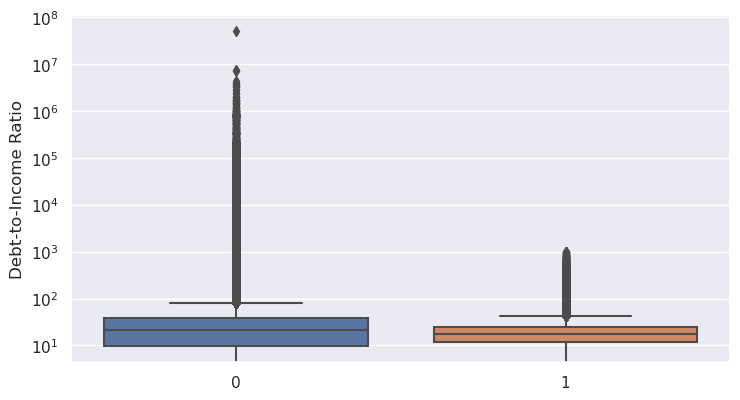

In [27]:
fig_dti_box, ax_dti_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxplot(
    x=data_full.select(["Debt-To-Income Ratio", "Policy Code"])
    .drop_nulls()["Policy Code"]
    .to_numpy(),
    y=data_full.select(["Debt-To-Income Ratio", "Policy Code"])
    .drop_nulls()["Debt-To-Income Ratio"]
    .to_numpy(),
    ax=ax_dti_box,
)

ax_dti_box.set_yscale("log")
ax_dti_box.set_ylabel("Debt-to-Income Ratio")
plt.show()

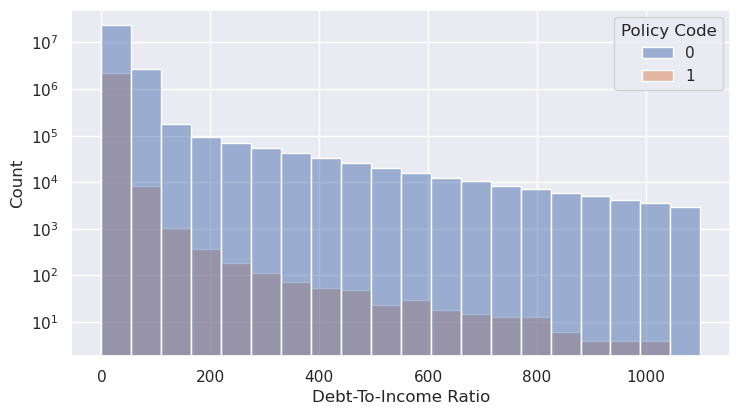

In [28]:
fig_dti_hist, ax_dti_hist = plt.subplots(figsize=BASE_FIG_SIZE)

sns.histplot(
    x=data_full.select(["Debt-To-Income Ratio", "Policy Code"])
    .drop_nulls()
    .filter(
        data_full.select(["Debt-To-Income Ratio", "Policy Code"]).drop_nulls()[
            "Debt-To-Income Ratio"
        ]
        < 1100
    )["Debt-To-Income Ratio"],
    hue=data_full.select(["Debt-To-Income Ratio", "Policy Code"]).drop_nulls().filter(
        data_full.select(["Debt-To-Income Ratio", "Policy Code"]).drop_nulls()[
            "Debt-To-Income Ratio"
        ]
        < 1100
    )[
        "Policy Code"
    ],
    bins=20,
    ax=ax_dti_hist,
)
plt.yscale("log")
plt.show()

### Date

In [29]:
applications_by_year=data_full.drop_nulls(subset="Application Date").sort(
    "Application Date"
).group_by_dynamic("Application Date", every="1y").agg(
    pl.col("Policy Code").sum().alias('accepted_count'),pl.col("Policy Code").count().alias('count')
)

applications_by_year = applications_by_year.with_columns(
    (pl.col("accepted_count") / pl.col("count") * 100).alias(
        "accepted_percentage"
    )
)

applications_by_year = applications_by_year.with_columns(
    pl.col("Application Date").dt.year().alias("year")
)

In [30]:
data_full=data_full.with_columns(pl.col("Application Date").dt.month().alias('month'))

In [31]:
data_full = data_full.with_columns(
    pl.col("month")
    .map_elements(lambda x: np.sin(x / 12 * 2 * np.pi))
    .alias("month_sin")
)

data_full = data_full.with_columns(
    pl.col("month")
    .map_elements(lambda x: np.cos(x / 12 * 2 * np.pi))
    .alias("month_cos")
)

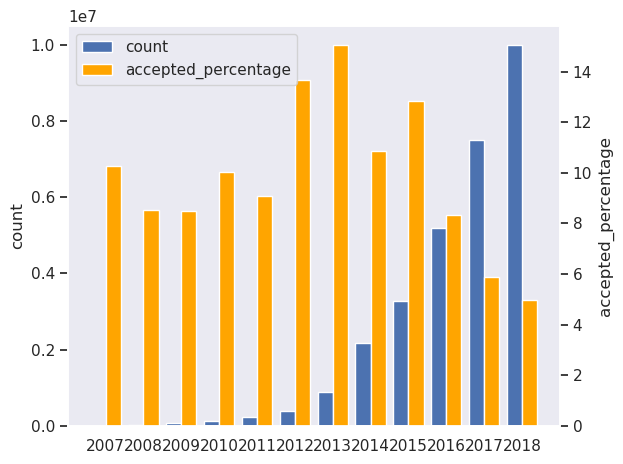

In [32]:
pf.plot_grouped_bars(
    applications_by_year, "year", col1="count", col2="accepted_percentage",legend_args={"loc":"upper left"}
)

#### Month

In [33]:
applications_by_month = (
    data_full.drop_nulls(subset="Application Date")
    .sort("Application Date")
    .group_by("month")
    .agg(
        pl.col("Policy Code").sum().alias("accepted_count"),
        pl.col("Policy Code").count().alias("count"),
    )
)

applications_by_month = applications_by_month.with_columns(
    (pl.col("accepted_count") / pl.col("count") * 100).alias("accepted_percentage")
)



In [34]:
applications_by_month

month,accepted_count,count,accepted_percentage
u32,i32,u32,f64
12,194892,2773304,7.02743
5,180324,2399556,7.51489
7,212699,2819341,7.544281
10,229215,2943660,7.786735
2,151786,1759093,8.628651
8,202454,2803091,7.222527
6,176513,2470762,7.144071
11,207032,2801682,7.389561
1,163373,2066791,7.90467


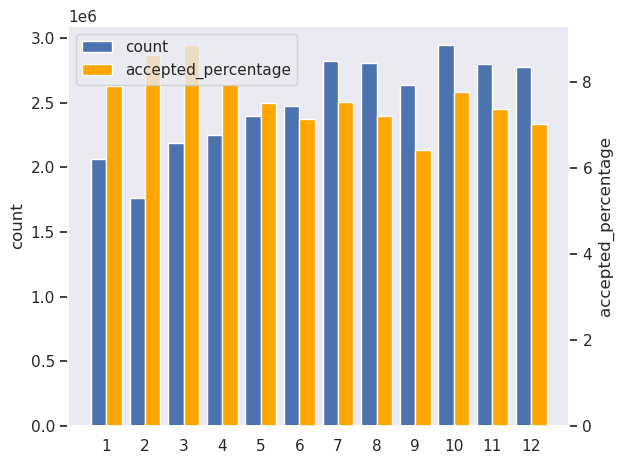

In [35]:
pf.plot_grouped_bars(
    applications_by_month, "month", col1="count", col2="accepted_percentage",legend_args={"loc":"upper left"}
)

In [36]:
state_counts=data_full.group_by('State').agg(
    pl.count().alias('Application Count'),
    (pl.sum('Policy Code')/pl.count()*100).alias('Accepted Percentage')
)

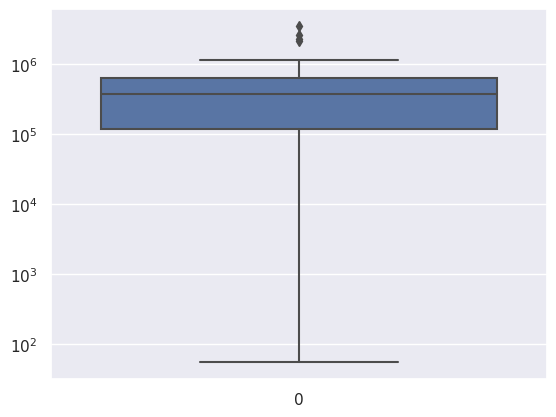

In [37]:
sns.boxplot(state_counts['Application Count'])
plt.yscale('log')

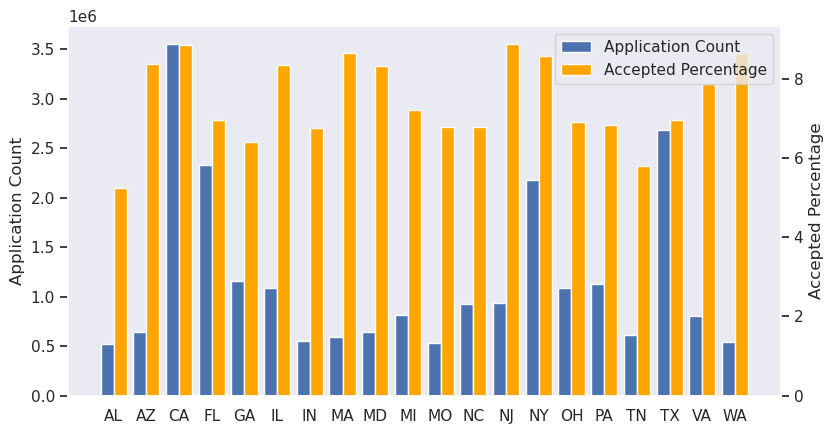

In [38]:
fig_state_counts, ax_state_counts = pf.plot_grouped_bars(
    state_counts, return_fig=True, top_vals=20,figsize_args={'figsize':BASE_FIG_SIZE}
)

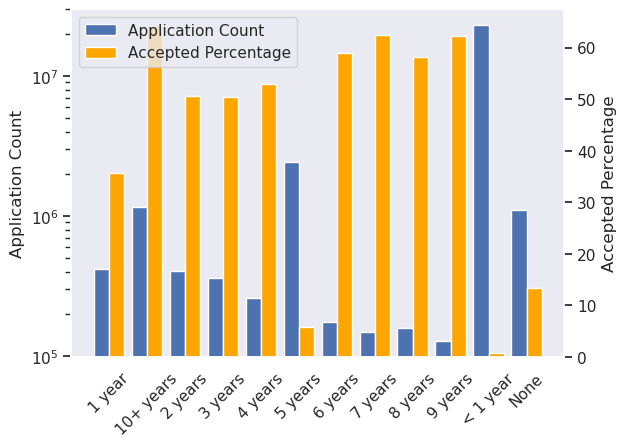

In [39]:
work_time_counts = data_full.group_by("Employment Length").agg(
    pl.count().alias("Application Count"),
    (pl.sum("Policy Code") / pl.count() * 100).alias("Accepted Percentage"),
)
work_time_counts = work_time_counts.fill_null("None")

fig_emp_length, ax_empl_length = pf.plot_grouped_bars(
    work_time_counts, x_label_args={"rotation": 45}, return_fig=True
)

ax_empl_length[0].set_yscale('log')

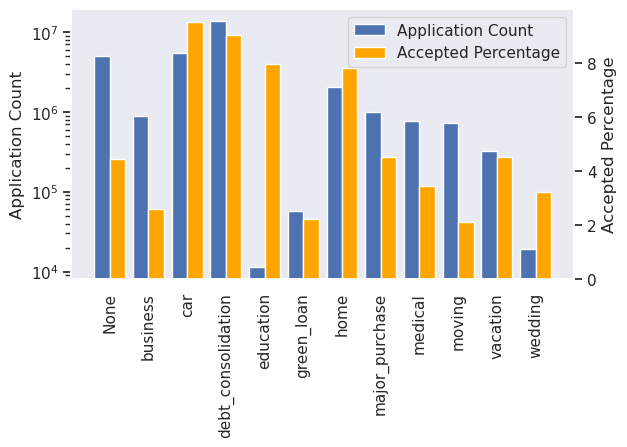

In [40]:
title_counts = data_full.group_by("title").agg(
    pl.count().alias("Application Count"),
    (pl.sum("Policy Code") / pl.count() * 100).alias("Accepted Percentage"),
)
title_counts = title_counts.fill_null("None")

fig_title, ax_title = pf.plot_grouped_bars(
    title_counts, x_label_args={"rotation": 90}, return_fig=True
)

ax_title[0].set_yscale('log')

### Splits

In [41]:
class_imbalance = (
    data_full["Policy Code"].value_counts()["counts"][1]
    / data_full["Policy Code"].value_counts()["counts"][0]
)
round(class_imbalance,3)

0.082

In [42]:
len(data_full.filter(data_full['Application Date'].dt.year()==2018))/len(data_full)

0.33407590820316874

In [43]:
data_full_train = data_full.filter(data_full['Application Date'].dt.year()!=2018)
data_full_test = data_full.filter(data_full['Application Date'].dt.year()==2018)

In [44]:
data_full_val,data_full_test = train_test_split(data_full_test,
    stratify=data_full_test["Policy Code"],
    train_size=0.3,
    random_state=1,
)

In [45]:
data_full_train.write_parquet('data/data_full_train.parquet')
data_full_val.write_parquet('data/data_full_val.parquet')


In [74]:
data_accepted.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,date,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
"""68407277""",null,3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,…,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68355089""",null,24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""small_business…","""Business""","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,…,24667.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68341763""",null,20000.0,20000.0,20000.0,""" 60 months""",10.78,432.66,"""B""","""B4""","""truck driver""","""10+ years""","""MORTGAGE""",63000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""home_improveme…",null,"""605xx""","""IL""",10.78,0.0,"""Aug-2000""",695.0,699.0,0.0,null,null,6.0,0.0,7869.0,56.2,18.0,…,14877.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""66310712""",null,35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…",2015-12-01,"""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,…,18000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68476807""",null,10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…",2015-12-01,"""Fully Paid""","""n""","""https://lendin…",null,"""major_purchase…","""

In [93]:
data_accepted["id"].is_duplicated().any()

False

In [69]:
null_counts_accepted = data_accepted.null_count() / len(data_accepted) * 100
# for col in null_counts_accepted.columns:
#     null_counts_accepted = null_counts_accepted.with_columns(
#         pl.col(col).map_elements(lambda x: f"{x:.2f}%").alias(col)
#     )
null_counts_accepted=pl.DataFrame({"feature": null_counts_accepted.columns}).with_columns(
    null_counts_accepted.transpose().to_series().alias("missing %")
)
null_counts_accepted.filter(null_counts_accepted['missing %']>=50)

feature,missing %
str,f64
"""member_id""",100.0
"""desc""",94.423544
"""mths_since_las…",51.246715
"""mths_since_las…",84.113069
"""next_pymnt_d""",59.509993
"""mths_since_las…",74.30996
"""annual_inc_joi…",94.660506
"""dti_joint""",94.660683
"""verification_s…",94.880791


In [88]:
drop_list = [
    "id"
    "member_id",
    "desc",
]  # 100% missing and a difficult to parse and rare text description.
drop_list.extend(
    [col for col in data_accepted.columns if "hardship" in col]
)  # related to the already given loan and not available for new loans.

drop_list.extend(
    [col for col in data_accepted.columns if "settlement" in col]
)  # related to the already given loan and not available for new loans.

drop_list.extend(['deferral_term'])

In [89]:
drop_list

['member_id',
 'desc',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term',
 'deferral_term']

In [90]:
data_accepted=data_accepted.drop(columns=drop_list)

In [94]:
data_accepted.head()

id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,…,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,payment_plan_start_date,orig_projected_additional_accrued_interest,disbursement_method
str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,date,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""68407277""",3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…","""debt_consolida…","""Debt consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,"""w""",0.0,…,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash"""
"""68355089""",24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…","""small_business…","""Business""","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,"""w""",0.0,…,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash"""
"""68341763""",20000.0,20000.0,20000.0,""" 60 months""",10.78,432.66,"""B""","""B4""","""truck driver""","""10+ years""","""MORTGAGE""",63000.0,"""Not Verified""",2015-12-01,"""Fully Paid""","""n""","""https://lendin…","""home_improveme…",null,"""605xx""","""IL""",10.78,0.0,"""Aug-2000""",695.0,699.0,0.0,null,null,6.0,0.0,7869.0,56.2,18.0,"""w""",0.0,…,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash"""
"""66310712""",35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…",2015-12-01,"""Current""","""n""","""https://lendin…","""debt_consolida…","""Debt consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,"""w""",15897.65,…,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash"""
"""68476807""",10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…",2015-12-01,"""Fully Paid""","""n""","""https://lendin…","""major_purchase…","""Major purchase…","""174xx""","""PA""",25.37,1.0,"""Jun-1998""",695.0,699.0,3.0,12.0,null,12.0,0.

### Formatting